# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Описание услуг

Оператор предоставляет два основных типа услуг:

1.	Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2.	Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

-	Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
-	Выделенная линия технической поддержки (TechSupport);
-	Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
-	Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Описание данных

Данные состоят из файлов, полученных из разных источников:
-	contract_new.csv — информация о договоре;
-	personal_new.csv — персональные данные клиента;
-	internet_new.csv — информация об интернет-услугах;
-   phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

**Цель проекта:** спрогнозировать уйдет клиент оператора связи «Ниединогоразрыва.ком» в ближайшее время или нет.

**Содержание (план) проекта:**

1. Подготовка данных

     1.1. Открытие и изучение файлов
     
     1.2. Предобработка данных
     
          1.2.1. Объединение таблиц
          1.2.2. Обработка пропущенных значений
          1.2.3. Преобразование типов данных
          1.2.4. Проверка на дубликаты
          1.2.5. Выявление выбросов и аномалий
          1.2.6. Добавление новых столбцов (с целевым признаком, с  длительностью обслуживания)
2. Исследовательский анализ данных

    2.1. Проверка на дисбаланс классов
    
    2.2. Сравнение распределения признаков для ушедших и оставшихся клиентов
    
    2.3. Исследование корреляции между признаками
    

3. Обучение моделей

    3.1. Подготовка выборок для обучения моделей
    
    3.2. Обучение моделей и оценка их качества кросс-валидацией
    
          3.2.1. LogisticRegression
          3.2.2. RandomForestClassifier
          3.2.3. CatBoostClassifier
          
4. Тестирование лучшей модели.

## 1 Подготовка данных

In [ ]:
!pip install phik

     |████████████████████████████████| 679 kB 1.8 MB/s eta 0:00:01


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostClassifier, Pool
import phik
import warnings
warnings.filterwarnings("ignore")

### 1.1 Открытие и изучение файлов

In [ ]:
contract_new = pd.read_csv('/datasets/contract_new.csv')

In [ ]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [ ]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contract_new.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [ ]:
personal_new = pd.read_csv('/datasets/personal_new.csv')

In [ ]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal_new.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
internet_new = pd.read_csv('/datasets/internet_new.csv')

In [ ]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


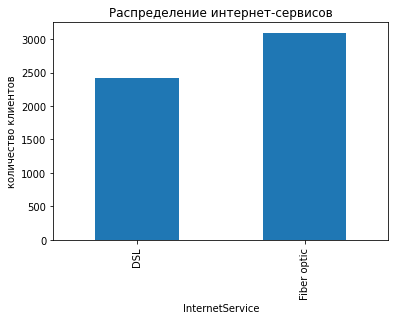

In [ ]:
(internet_new.pivot_table(values='customerID', index='InternetService', aggfunc='count').reset_index()
         .plot.bar(x='InternetService', xlabel='InternetService', ylabel='количество клиентов',
                       title='Распределение интернет-сервисов',legend=None)
);

In [ ]:
phone_new = pd.read_csv('/datasets/phone_new.csv')

In [ ]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


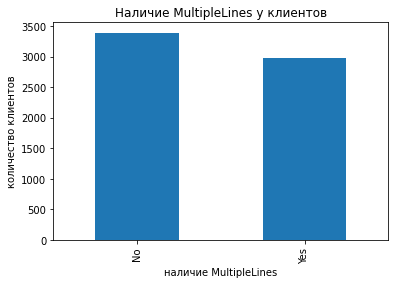

In [ ]:
phone_new['MultipleLines'].value_counts().plot.bar(xlabel='наличие MultipleLines',
                                                   ylabel='количество клиентов',
                                                   title='Наличие MultipleLines у клиентов');

Данные содержаться в 4 таблицах.
Таблица "contract_new" с  информацией о договоре содержит 7043 строк и 8 столбцов, все столбцы, кроме MonthlyCharges(float64), имеют тип данных object, столбец TotalCharges имеет тип - object, но содержит числовые значения. Таблица с персональными данными клиентов "personal_new"  сожержит также 7043 строк, но столбцов в ней 5, столбец SeniorCitizen имеет тип  int64 , остальные - object. Таблица c информацией об интернет-услугах "internet_new" содержит 5517 строк и 8 столбцов, тип данных во всех столбцах object. В таблице с информацией об услугах телефонии "phone_new" всего 2 столбца, 6361 строк, тип данных столбцов - object.

###1.2 Предобработка данных

####1.2.1 Объединение таблиц

In [ ]:
data = contract_new.merge(personal_new, how='outer')
data = data.merge(internet_new, how='outer')
data = data.merge(phone_new, how='outer')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Методом merge() объединены 4 таблицы в одну -"date", после объединения в таблице имеется пропуски.

####1.2.2 Обработка пропущенных значений

In [ ]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [ ]:
data = data.fillna('No')

In [ ]:
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Пропущенные значения заполнены значением "No", т.к. у данных клиентов данные услуги отсутствуют.

####1.2.3 Преобразование типов данных

In [ ]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

In [ ]:
data.loc[data['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [ ]:
data['EndDate'] = pd.to_datetime(data['EndDate'])

In [ ]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

In [ ]:
data[data['TotalCharges'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,No,No,No,No,No,No,No
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,No,No,No,No,No,No,No
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes


In [ ]:
data = data[data['BeginDate'] != '2020-02-01']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

В столбцах BeginDate и EndDate был изменен тип данных на datetime, предварительно в столбце EndDate все значения "No" были заменены на дату 2020-02-01, т.к. из описания данных известно, что информация о договорах актуальна на 1 февраля 2020. В столбце TotalCharges тип данных был изменен на float, после данного изменения в указанном столбце появились пропуски, строки с пропусками были удалены, т.к. это строки с пользователями, которые только заключили договор.

####1.2.4 Проверка на дубликаты

In [ ]:
data.duplicated().sum()

0

Дубликаты отсутствуют

####1.2.5 Выявление выбросов и аномалий

In [ ]:
data.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7032.000000,7032.000000,7032.000000
mean,64.798208,2118.621822,0.162400
std,30.085974,2112.736199,0.368844
min,18.250000,19.050000,0.000000
25%,35.587500,439.745000,0.000000
50%,70.350000,1345.275000,0.000000
75%,89.862500,3239.317500,0.000000
max,118.750000,9221.380000,1.000000


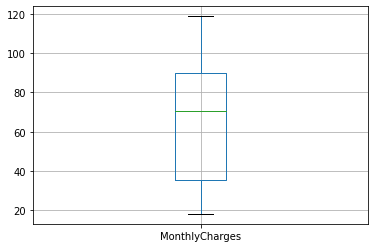

In [ ]:
data.boxplot(column='MonthlyCharges');

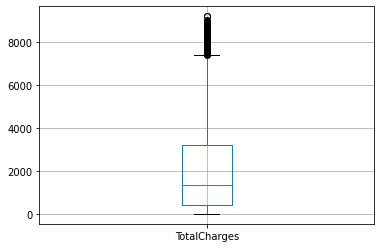

In [ ]:
data.boxplot(column='TotalCharges');

In [ ]:
data[data['TotalCharges']>7500]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
17,9959-WOFKT,2014-03-01,2020-02-01,Two year,No,Bank transfer (automatic),106.70,8257.51,Male,0,No,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes
57,5067-XJQFU,2014-08-01,2020-02-01,One year,Yes,Electronic check,108.45,7730.32,Male,1,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
59,5954-BDFSG,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),107.50,7740.00,Female,0,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
198,7255-SSFBC,2014-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),112.25,8324.46,Male,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
369,3520-FJGCV,2014-02-01,2020-02-01,Two year,Yes,Credit card (automatic),112.60,8755.78,Male,0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,3508-CFVZL,2014-03-01,2020-02-01,Two year,No,Mailed check,111.30,7902.30,Female,0,No,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6910,0530-IJVDB,2014-04-01,2020-02-01,Two year,Yes,Electronic check,114.60,8182.44,Male,0,No,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
6913,8213-TAZPM,2014-05-01,2020-02-01,One year,Yes,Bank transfer (automatic),108.75,7728.86,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
6992,0218-QNVAS,2014-03-01,2020-02-01,One year,No,Bank transfer (automatic),100.55,7638.78,Male,0,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Yes


Рассмотрены на выбросы столбцы MonthlyCharges и TotalCharges. В столбце MonthlyCharges выбросы отсутствуют, в столбце TotalCharges присутствуют значения превышающие верхнюю границу расчитанную по правилу 1,5*IQR, это клиенты у которых высокая стоимость услуг и высокая длительность обслуживания, эти данные целесообразнее оставить.

####1.2.6 Добавление новых столбцов

In [ ]:
data['Target'] = np.where(data['EndDate']=='2020-02-01', 0, 1)

In [ ]:
data['Service_duration'] = (data['EndDate'] - data['BeginDate']).astype('timedelta64[D]')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

In [ ]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,Service_duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036.0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371.0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153.0


В данные добавлены два новых столбца - столбец с целевым признаком 'Target' и столбец с длительностью обслуживания 'Service_duration'

Данные из 4 таблиц были объединены в одну, полученные после объединения пропуски были заполненные значением "No". В столбцах BeginDate и EndDate был изменен тип данных на datetime, предварительно в столбце EndDate все значения "No" были заменены на дату 2020-02-01. В столбце TotalCharges тип данных был изменен на float, после чего появившиеся в нем строки с пропусками были удалены, т.к. это строки с пользователями, которые только заключили договор. Были рассмотрены на выбросы столбцы MonthlyCharges и TotalCharges. В данные были добавлены два новых столбца - столбец с целевым признаком 'Target' и столбец с длительностью обслуживания 'Service_duration'

##2 Исследовательский анализ данных

###2.1 Проверка на дисбаланс классов

In [ ]:
data.groupby('Target').size()/len(data)

Target
0    0.84343
1    0.15657
dtype: float64

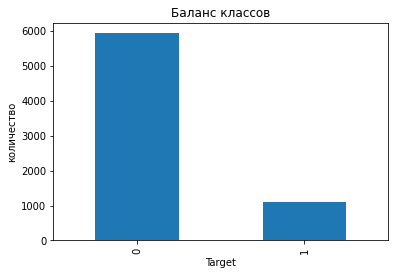

In [ ]:
data['Target'].value_counts().plot.bar(xlabel='Target', ylabel='количество', title='Баланс классов');

Присутствует дисбаланс классов

###2.2 Сравнение распределения признаков для ушедших и оставшихся клиентов

In [ ]:
def func(name, title):
    (data.pivot_table(index='Target', columns=name, values='customerID', aggfunc='count').reset_index(drop=True)
         .plot.bar(xlabel='Target', ylabel='количество клиентов',
                   title=title, grid=True)
    );

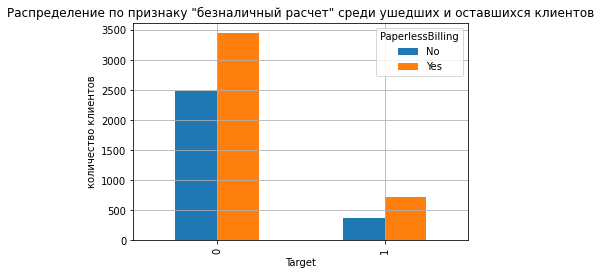

In [ ]:
func('PaperlessBilling', 'Распределение по признаку "безналичный расчет" среди ушедших и оставшихся клиентов')

Распределение по признаку "безналичный расчет" среди ушедших и оставшихся клиентов похожее, но по пропорциям немного различается. Данный признак скорее всего сильное влияние не оказывает.

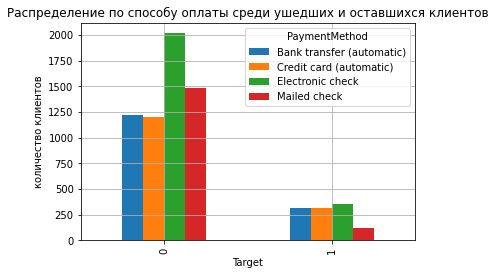

In [ ]:
func('PaymentMethod', 'Распределение по способу оплаты среди ушедших и оставшихся клиентов')

Среди ушедших клиентов доля использовавших способ оплаты Mailed check самая маленькая. Данный признак может оказывать влияние.

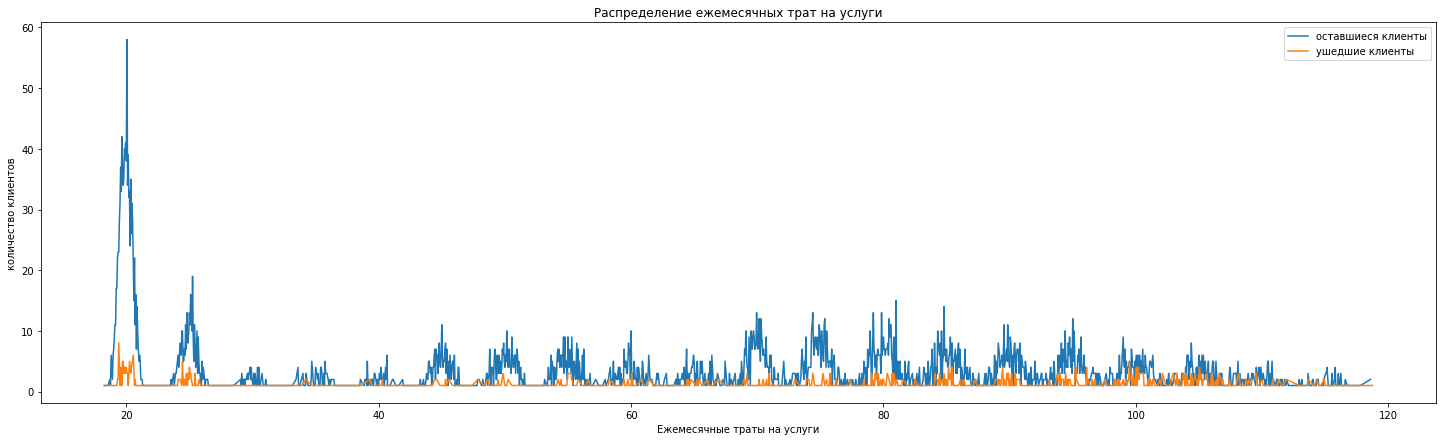

In [ ]:
plt.figure(figsize=(25, 7))
plt.plot('MonthlyCharges', 'customerID',
         data=data[data['Target']==0].pivot_table(index='MonthlyCharges', values='customerID', aggfunc='count')
         .reset_index())
plt.plot('MonthlyCharges', 'customerID',
         data=data[data['Target']==1].pivot_table(index='MonthlyCharges', values='customerID', aggfunc='count')
         .reset_index())
#plt.xticks(np.arange(0, 2400, step=100))
plt.xlabel('Ежемесячные траты на услуги')
plt.ylabel('количество клиентов')
plt.title('Распределение ежемесячных трат на услуги')
plt.legend(['оставшиеся клиенты', 'ушедшие клиенты'], loc='upper right')
plt.show()

 Распределение ежемесячных трат имеет отличия и может оказывать влияние.

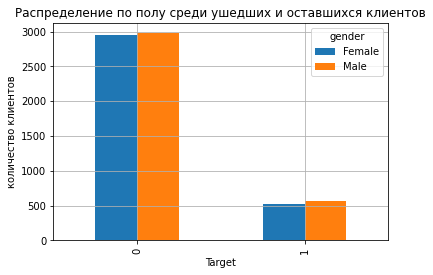

In [ ]:
func('gender', 'Распределение по полу среди ушедших и оставшихся клиентов')

Распределение по полу среди ушедших и оставшихся клиентов идентичное. Данный признак влияние оказывать не будет.

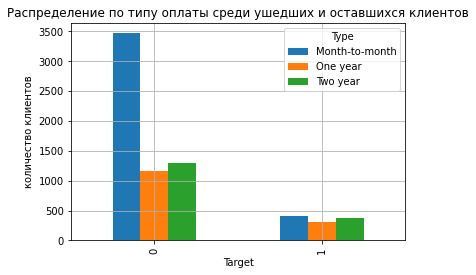

In [ ]:
func('Type', 'Распределение по типу оплаты среди ушедших и оставшихся клиентов')

Большинство действующих клиентов используют способ оплаты - помесяный, в тоже время распределение у ушедших клиентов среди имеющихся трех типов оплаты практически одинаковое.Данный признак может оказывать влияние.

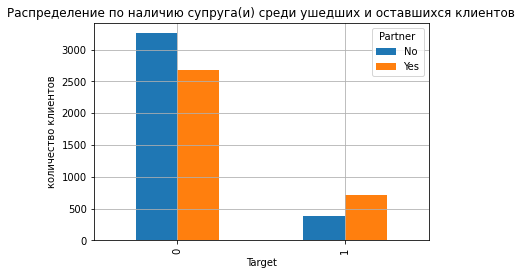

In [ ]:
func('Partner', 'Распределение по наличию супруга(и) среди ушедших и оставшихся клиентов')

Среди ушедших клиентов доля состоящих в браке выше, а среди оставшихся ниже, данный признак может оказывать влияние.

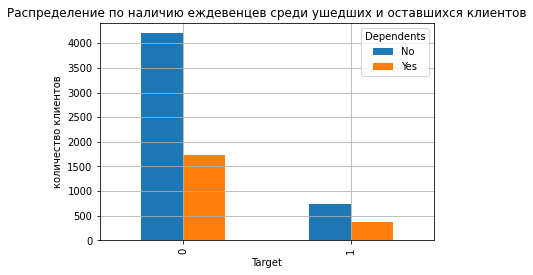

In [ ]:
func('Dependents', 'Распределение по наличию еждевенцев среди ушедших и оставшихся клиентов')

Распределение по наличию еждевенцев среди ушедших и оставшихся клиентов похожее, но различается немного по пропорциям. Данный признак скорее всего не оказывает сильное влияние.

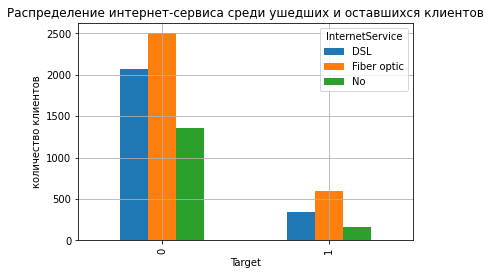

In [ ]:
func('InternetService', 'Распределение интернет-сервиса среди ушедших и оставшихся клиентов')

Распределение интернет-сервиса среди ушедших и оставшихся клиентов похожее, различается по пропорциям(оставшиеся DSL пользуютя где-то процентов на 15 меньше, чем Fiber optic, а у ушедших разница между сервисами почти в 2 раза). Данный признак скорее всего  имеет не сильное влияние.

In [ ]:
target_0 = []
target_1 = []

for i in data.columns[13:-2]:
    table_0 = data[data['Target'] == 0][i].value_counts()
    target_0.append(table_0)
    table_1 = data[data['Target'] == 1][i].value_counts()
    target_1.append(table_1)

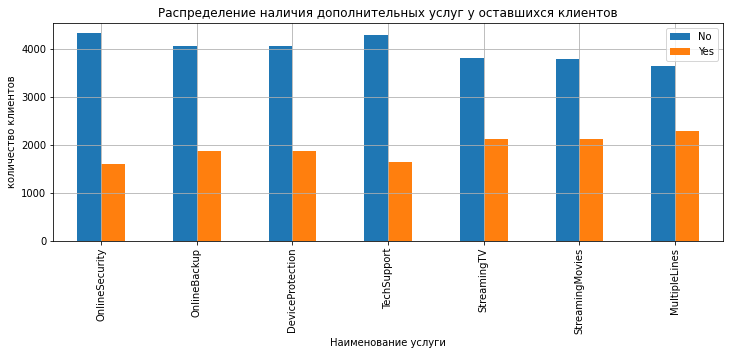

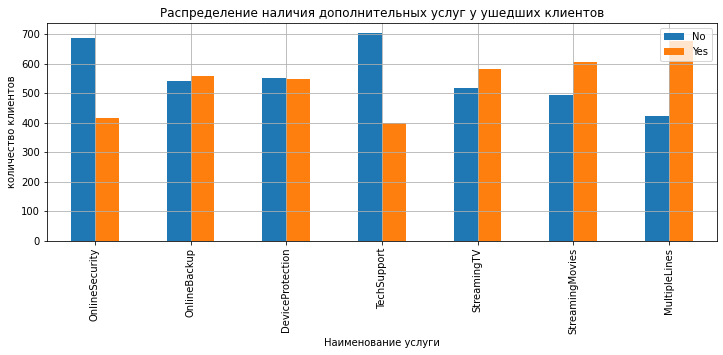

In [ ]:
pd.DataFrame(target_0).plot.bar(xlabel='Наименование услуги', ylabel='количество клиентов',
                   title='Распределение наличия дополнительных услуг у оставшихся клиентов', figsize=(12,4), grid=True)
pd.DataFrame(target_1).plot.bar(xlabel='Наименование услуги', ylabel='количество клиентов',
                   title='Распределение наличия дополнительных услуг у ушедших клиентов', figsize=(12,4), grid=True);

Распределение наличия доп. услуг среди ушедших и оставшихся клиентов имеет различия, данные признаки могут иметь влияние.

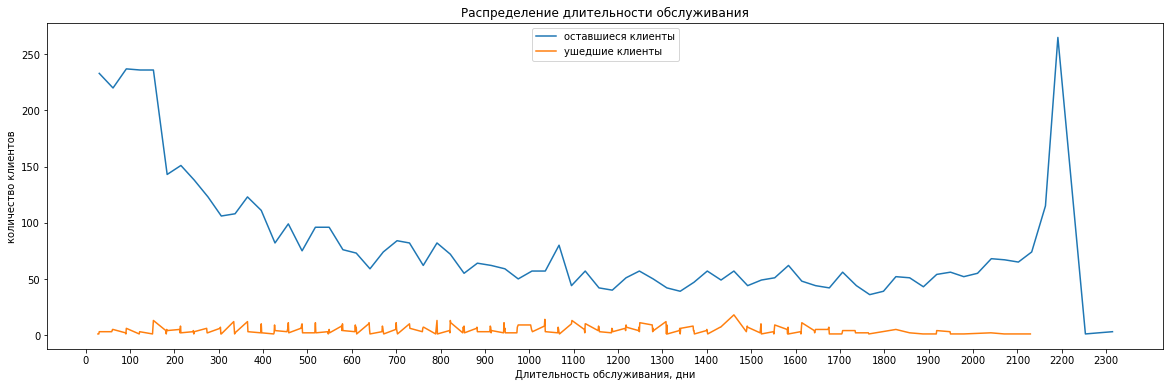

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot('Service_duration', 'customerID',
         data=data[data['Target']==0].pivot_table(index='Service_duration', values='customerID', aggfunc='count')
         .reset_index())
plt.plot('Service_duration', 'customerID',
         data=data[data['Target']==1].pivot_table(index='Service_duration', values='customerID', aggfunc='count')
         .reset_index())
plt.xticks(np.arange(0, 2400, step=100))
plt.xlabel('Длительность обслуживания, дни')
plt.ylabel('количество клиентов')
plt.title('Распределение длительности обслуживания')
plt.legend(['оставшиеся клиенты', 'ушедшие клиенты'], loc='upper center')
plt.show()

Распределение по длительности обслуживания среди ушедших клиентов довольно равномерное.

В рассматриваемых данных присутствуют признаки, которые в большей, либо в меньшей степени могут оказывать влияние, а есть признаки, которые скорее всего никакого влияния вообще не оказывают - распределение по полу.

###2.3 Исследование корреляции между признаками

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
data.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Target', 'Service_duration']


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,Service_duration
customerID,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BeginDate,1.0,1.000000,0.549761,0.765275,0.078664,0.467586,0.421848,0.773731,0.018540,0.049516,0.485513,0.201169,0.185601,0.414870,0.457995,0.468675,0.410714,0.369979,0.381092,0.440017,0.461977,0.978241
EndDate,1.0,0.549761,1.000000,0.286678,0.062480,0.168837,0.172986,0.215829,0.018351,0.090149,0.178225,0.056795,0.116149,0.129869,0.203878,0.197905,0.113035,0.164908,0.177174,0.209427,1.000000,0.399183
Type,1.0,0.765275,0.286678,1.000000,0.106151,0.277528,0.388557,0.470700,0.000000,0.085800,0.179294,0.146126,0.503776,0.152239,0.099016,0.137817,0.180169,0.067123,0.070375,0.065750,0.094622,0.635623
PaperlessBilling,1.0,0.078664,0.062480,0.106151,1.000000,0.368945,0.467547,0.202168,0.000000,0.241715,0.010489,0.170650,0.231145,0.000000,0.196937,0.161234,0.055354,0.344114,0.325351,0.253299,0.082789,0.018839
PaymentMethod,1.0,0.467586,0.168837,0.277528,0.368945,1.000000,0.398849,0.334563,0.000000,0.291989,0.244661,0.222859,0.323013,0.261704,0.282245,0.306678,0.270893,0.377241,0.378375,0.339987,0.214300,0.348275
MonthlyCharges,1.0,0.421848,0.172986,0.388557,0.467547,0.398849,1.000000,0.711015,0.005522,0.304546,0.204575,0.182283,0.919005,0.550855,0.629276,0.667621,0.576163,0.835680,0.833111,0.676393,0.225823,0.387649
TotalCharges,1.0,0.773731,0.215829,0.470700,0.202168,0.334563,0.711015,1.000000,0.000000,0.136856,0.383135,0.085809,0.489363,0.522660,0.623588,0.642431,0.550988,0.642937,0.644346,0.573224,0.303758,0.847572
gender,1.0,0.018540,0.018351,0.000000,0.000000,0.000000,0.005522,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.016788,0.007277,0.000000,0.000000,0.000000,0.000000,0.000000,0.008800,0.000000
SeniorCitizen,1.0,0.049516,0.090149,0.085800,0.241715,0.291989,0.304546,0.136856,0.000000,1.000000,0.018075,0.323629,0.160452,0.056897,0.102206,0.090818,0.092485,0.163223,0.185621,0.221386,0.085708,0.065128


Меджу двумя числовыми признаками MonthlyCharges и TotalCharges присутствует сильная положительная корреляция. Также присутствует сильная положительная корреляция между MonthlyCharges и InternetService,  StreamingTV,	StreamingMovies и умеренная между MonthlyCharges и другими доп. услугами. Между TotalCharges и доп. услугами присутствует умеренная корреляция. между TotalCharges и Service_duration сильная корреляция.

##3 Обучение моделей

###3.1 Подготовка выборок для обучения моделей

In [ ]:
RANDOM_STATE = 140823

In [ ]:
target = data['Target']
features = data.drop(['customerID', 'Target', 'BeginDate', 'EndDate','TotalCharges'], axis=1)

In [ ]:
target.shape, features.shape

((7032,), (7032, 17))

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE,
                                                                            stratify=target)

In [ ]:
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((5274, 17), (1758, 17), (5274,), (1758,))

In [ ]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('SeniorCitizen')
num_features

['MonthlyCharges', 'Service_duration']

In [ ]:
categ_features = features_train.select_dtypes(include='object').columns.to_list()
categ_features

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'gender',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

Для обучения будут использоваться все признаки кроме 'customerID'(т.к. это просто индентификатор клиента), 'BeginDate', 'EndDate' и 'TotalCharges'(это просто суммирующий нарастающим итогом столбец, кроме того мы наблюдали сильную корреляцию между MonthlyCharges и TotalCharges). Данные были разбиты на обучающую и тестовую выборки. Были созданы списки с наименованием столбцов с числовыми и категориальными признаками.

###3.2 Обучение моделей и оценка их качества кросс-валидацией

####3.2.1 LogisticRegression

In [ ]:
col_transformer_lr = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore', sparse=False),
        categ_features
    ),

    (
        StandardScaler(),
        num_features
    ),
        remainder='passthrough'
)
model_lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
pipline_lr = make_pipeline(col_transformer_lr, model_lr)
param_lr = {
      'logisticregression__solver': ('lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'),
      'logisticregression__C': [0.05, 0.1, 0.5, 1, 2]
           }
rs_lr = RandomizedSearchCV(
                pipline_lr,
                param_distributions = param_lr,
                scoring='roc_auc',
                n_jobs=-1,
                random_state=RANDOM_STATE,
                cv=5
                          )
rs_lr.fit(features_train, target_train)
rs_lr_best_score = rs_lr.best_score_
rs_lr_best_params = rs_lr.best_params_
acc_lr = cross_val_score(rs_lr.best_estimator_, features_train, target_train, cv=5, scoring='accuracy').mean()
print('AUC-ROC наилучшей модели:', rs_lr_best_score)
print('Accuracy:', acc_lr)
print('Параметры наилучшей модели:', rs_lr_best_params)

AUC-ROC наилучшей модели: 0.7596319859638501
Accuracy: 0.6981418563450452
Параметры наилучшей модели: {'logisticregression__solver': 'newton-cg', 'logisticregression__C': 0.1}


Модель LogisticRegression была обучена и проверена кросс-валидацией с использованием pipeline, внутри которого данные были закодированы и масштабированы. Лучший результат с метриками качества AUC-ROC: 0.7596319859638501, Accuracy: 0.6981418563450452 показала модель с параметрами 'logisticregression__solver': 'newton-cg', 'logisticregression__C': 0.1.

####3.2.2 RandomForestClassifier

In [ ]:
col_transformer_rf = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore', sparse=False),
        categ_features
    ),
       remainder='passthrough'
)
model_rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_rf = {
    'randomforestclassifier__n_estimators': range(50, 351, 50),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4),
    'randomforestclassifier__criterion': ('gini', 'entropy', 'log_loss')
    }

rs_rf = RandomizedSearchCV(
    pipline_rf,
    param_distributions=param_rf,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    cv=4
)

rs_rf.fit(features_train, target_train)
acc_rf = cross_val_score(rs_rf.best_estimator_, features_train, target_train, cv=4, scoring='accuracy').mean()
rs_rf_best_score = rs_rf.best_score_
rs_rf_best_params = rs_rf.best_params_
print('AUC-ROC наилучшей модели:', rs_rf_best_score)
print('Accuracy:', acc_rf)
print('Параметры наилучшей модели:', rs_rf_best_params)

AUC-ROC наилучшей модели: 0.8216693688105656
Accuracy: 0.8073566733891611
Параметры наилучшей модели: {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'entropy'}


Модель RandomForestClassifier была обучена и проверена кросс-валидацией с использованием pipeline, внутри которого данные были закодированы. Лучший результат с метриками качества AUC-ROC: 0.8216693688105656, Accuracy: 0.8073566733891611 показала модель с параметрами 'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'entropy'.

####3.2.3 CatBoostClassifier

In [ ]:
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, eval_metric='AUC', auto_class_weights='Balanced',
                              cat_features=categ_features)
param_cb = {
    'iterations': range(50, 351, 50),
    'depth': range(2, 15)
    }

rs_cb = RandomizedSearchCV(
    model_cb,
    param_distributions=param_cb,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    cv=4
)
rs_cb.fit(features_train, target_train, verbose=50)
rs_cb_best_score = rs_cb.best_score_
rs_cb_best_params = rs_cb.best_params_
acc_cb = cross_val_score(rs_cb.best_estimator_, features_train, target_train, cv=5, scoring='accuracy').mean()
print('AUC-ROC наилучшей модели:', rs_cb_best_score)
print('Accuracy:', acc_cb)
print('Параметры наилучшей модели:', rs_cb_best_params)

Learning rate set to 0.055898
0:	total: 79.8ms	remaining: 23.9s
50:	total: 7.49s	remaining: 36.6s
100:	total: 13.6s	remaining: 26.8s
150:	total: 22.3s	remaining: 22s
200:	total: 42.5s	remaining: 20.9s
250:	total: 1m 3s	remaining: 12.3s
299:	total: 1m 25s	remaining: 0us
Learning rate set to 0.055898
0:	total: 476ms	remaining: 2m 22s
50:	total: 9.24s	remaining: 45.1s
100:	total: 17.2s	remaining: 33.8s
150:	total: 23.6s	remaining: 23.2s
200:	total: 42.3s	remaining: 20.8s
250:	total: 1m 5s	remaining: 12.9s
299:	total: 1m 26s	remaining: 0us
Learning rate set to 0.055904
0:	total: 16.7ms	remaining: 5s
50:	total: 7.47s	remaining: 36.5s
100:	total: 14.5s	remaining: 28.6s
150:	total: 25.4s	remaining: 25.1s
200:	total: 44.2s	remaining: 21.8s
250:	total: 1m 7s	remaining: 13.1s
299:	total: 1m 29s	remaining: 0us
Learning rate set to 0.055904
0:	total: 18.6ms	remaining: 5.57s
50:	total: 10.6s	remaining: 51.7s
100:	total: 17.2s	remaining: 33.8s
150:	total: 26.5s	remaining: 26.2s
200:	total: 46.9s	rem

Модель CatBoostClassifier была обучена и проверена кросс-валидацией  Лучший результат с метриками качества AUC-ROC: 0.8631658782302989, Accuracy: 0.8062170742016421 показала модель с параметрами 'iterations': 300, 'depth': 6.

In [ ]:
result = pd.DataFrame([['LogisticRegression', rs_lr_best_score, acc_lr],
                       ['RandomForestClassifier', rs_rf_best_score, acc_rf],
                       ['CatBoostClassifier',rs_cb_best_score, acc_cb]],
                       columns=['модель', 'AUC-ROC', 'Accuracy'])
result

,модель,AUC-ROC,Accuracy
0,LogisticRegression,0.759632,0.698142
1,RandomForestClassifier,0.821669,0.807357
2,CatBoostClassifier,0.863166,0.806217


Были обучены модели LogisticRegression, RandomForestClassifier, CatBoostClassifier и проверены кросс-валидацией с использованием RandomizedSearchCV для подбора гиперпараметров. Для проверки качества моделей использовались метрики AUC-ROC и Accuracy. Лучшие результаты показала модель CatBoostClassifier с параметрами 'iterations': 300, 'depth': 6. Данная модель будет проверена на тестовой выборке.

##4 Тестирование лучшей модели

In [ ]:
predict_test = rs_cb.predict(features_test)
acc_test = accuracy_score(target_test, predict_test)
probabilities_test = rs_cb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_test = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC:', auc_test)
print('Accuracy:', acc_test)

AUC-ROC: 0.8744645374854411
Accuracy: 0.8031854379977247


После тестирования модель показала метрики качества AUC-ROC: 0.8744645374854411, Accuracy: 0.8031854379977247.

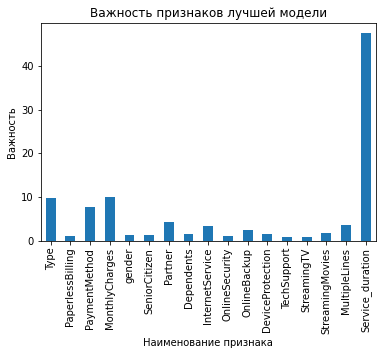

In [ ]:
cb_feature_importance = pd.DataFrame(rs_cb.best_estimator_.get_feature_importance(), features_test.columns)
cb_feature_importance.plot.bar(xlabel='Наименование признака', ylabel='Важность',
                               title='Важность признаков лучшей модели', legend=None);

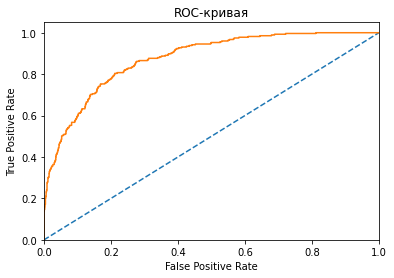

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0., 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC-кривая")
plt.show()

# Отчет

Целью проекта являлось построение модели, которая сможет спрогнозировать уйдет клиент оператора связи «Ниединогоразрыва.ком» в ближайшее время или нет.
В нашем распоряжении были данные, состоящие из 4 файлов, полученных из разных источников с информацией о договоре, персональных данных клиента, об интернет-услугах и услугах телефонии.
Для реализации поставленной цели в первую очередь был составлен план проекта, состоящий из 4 основных пунктов с подпунктами. При работе все запланированные пункты были исполнены и структура плана была полностью соблюдена.
В реализации данного проекта никаких затруднений не возникало, все этапы выполнялись в соответствии с планом.
Проект состоит из четырех основных этапов: подготовка данных, исследовательский анализ данных, обучение моделей, тестирование лучшей модели. Все этапы важны и выявить ключевые не представляется возможным, т.к. все этапы последовательно приводят к требуемому результату. Подготовка данных позволила избежать искажений и ошибок в дальнейшем обучении, исследовательский анализ данных помог определить признаки для обучения, обучение моделей с их оценкой кросс-валидацией с подбором гиперпараметров позволили выявить лучшую модель, тестирование модели подтвердило правильность сделанного выбора.
Первым этапом работы являлась подготовка данных. На данном этапе данные из четырех таблиц были объединены в одну, образовавшиеся пропуски были заполнены значением “No”. Кроме того, были преобразованы типы данных, выполнена проверка на дубликаты. Были удалены строки с пустыми значениями в столбце «TotalCharges» (т.к. это строки с пользователями, которые только заключили договор). Также данные были проверены на выбросы и аномалии. Одним из важных моментов данного этапа проекта было добавление новых столбцов: с длительностью обслуживания («Service_duration») и собственно столбца с целевым значением («Target»).
Далее был проведен исследовательский анализ данных. Был обнаружен дисбаланс классов, были рассмотрены признаки и сделаны предположения об их влиянии либо отсутствии влияния на отток клиентов. Также с помощью библиотеки phik была исследована корреляция между признаками, так в частности была обнаружена сильная положительная корреляция между числовыми признаками MonthlyCharges и TotalCharges и между TotalCharges и Service_duration.
Следующим этапом было обучение моделей. Для обучения использовались следующие признаки:
*   числовые признаки: 'MonthlyCharges', 'Service_duration'
*   категориальные признаки: 'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', ‘SeniorCitizen’, 'Partner', 'Dependents', 'InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','MultipleLines.

Не использовались - 'customerID'(т.к. это просто идентификатор клиента), 'BeginDate', 'EndDate' и 'TotalCharges'(это просто суммирующий нарастающим итогом столбец, кроме того мы наблюдали сильную корреляцию между MonthlyCharges, Service_duration и TotalCharges).
Был зафиксирован параметр RANDOM_STATE = 140823. Данные были разбиты на обучающую и тестовую выборки, размер тестовой выборки = 0.25.
Для оценки качества моделей были выбраны две метрики AUC-ROC и Accuracy. Были обучены и протестированы кросс-валидацией три модели: LogisticRegression, RandomForestClassifier, CatBoostClassifier. Для подготовки признаков и обучения моделей использовался Pipeline. При помощи RandomizedSearchCV был выполнен подбор гиперпараметров моделей. Т.к. был выявлен дисбаланс классов внутри моделей использовался параметр class_weight=’balanced’.
Модель LogisticRegression показала результат AUC-ROC: 0.7596319859638501, Accuracy: 0.6981418563450452 с параметрами 'logisticregression__solver': 'newton-cg', 'logisticregression__C': 0.1.
Модель RandomForestClassifier показала результат AUC-ROC: 0.8216693688105656, Accuracy: 0.8073566733891611 с параметрами 'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 8, 'randomforestclassifier__criterion': 'entropy'.
Лучшие результаты AUC-ROC: 0.8631658782302989, Accuracy: 0.8062170742016421 были получены у модели CatBoostClassifier.
Параметры лучшей модели CatBoostClassifier: auto_class_weights='Balanced', iterations=300, depth=6.
Лучшая модель была проверена на тестовой выборке. Качество модели на тестовой выборке не ухудшилось. В результате тестирования модель показала метрики качества AUC-ROC: 0.8744645374854411, Accuracy: 0.8031854379977247.
Также был проведен анализ важности признаков лучшей модели, который показал, что самым главным признаком, влияющим на отток является 'Service_duration', также хотя и со значительным отрывом выделяются 'Type', 'PaymentMethod', 'MonthlyCharges'. На данные признаки руководству «Ниединогоразрыва.ком» можно рекомендовать обратить особое внимание.
